In [123]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk

from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score,recall_score
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

import pickle


In [2]:
import snscrape.modules.twitter as sntwit
import pandas as pd
from tqdm import tqdm

import pymongo

import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [3]:
hastags = pd.read_excel ("data/Hashtags_csv.xlsx")


In [4]:
hastags.head()

,Mots clés
0,Racisme anti-noir
1,Racisme anti-asiatique
2,Racisme dans le cinéma français
3,Négrophobie
4,Suprématie blanche


#### Importation et exploration des données

In [5]:
#Importation du fichier
tweets = pd.read_json("tweets_new.json")

tweets.head()

,id,date,contenu,utilisateur,nbre_like,nbre_retweet,mots_cles
0,1635039793305493506,2023-03-12 22:07:18,@Hamou_Rabi2 @MaudPK @r_chekkat @SoMabrouk Com...,DavidJo66949427,0,0,Racisme anti-noir
1,1635029907192553472,2023-03-12 21:28:01,@LDenfo @jeraeve Le racisme anti noir est vécu...,rirettemj,0,0,Racisme anti-noir
2,1635020796111486977,2023-03-12 20:51:49,@alexsyl973 Classer un pays comme puissance co...,Nipiloma,0,0,Racisme anti-noir
3,1635010403234353154,2023-03-12 20:10:31,@QuelleEpoqueOff @France2tv @LeaSalame Oh la l...,JeanSeb28049650,0,0,Racisme anti-noir
4,1635005488315379712,2023-03-12 19:51:00,@LCP @tgassilloud Vous déprogrammez aussi Eric...,BenatiaMedhi,6,0,Racisme anti-noir


In [6]:
tweets.dtypes

id                       int64
date            datetime64[ns]
contenu                 object
utilisateur             object
nbre_like                int64
nbre_retweet             int64
mots_cles               object
dtype: object

In [7]:
tweets.columns

Index(['id', 'date', 'contenu', 'utilisateur', 'nbre_like', 'nbre_retweet',
       'mots_cles'],
      dtype='object')

In [8]:
tweets.describe(include='object')

,contenu,utilisateur,mots_cles
count,467,467,467
unique,453,424,42
top,"Chère @sandrousseau , que pensez-vous de cette...",Acamus19,Discrimination intersectionnelle
freq,2,5,22


In [9]:
text_df = tweets.drop(['id', 'date', 'utilisateur', 'nbre_like', 'nbre_retweet',
       'mots_cles'], axis = 1)

In [10]:
text_df.head()

,contenu
0,@Hamou_Rabi2 @MaudPK @r_chekkat @SoMabrouk Com...
1,@LDenfo @jeraeve Le racisme anti noir est vécu...
2,@alexsyl973 Classer un pays comme puissance co...
3,@QuelleEpoqueOff @France2tv @LeaSalame Oh la l...
4,@LCP @tgassilloud Vous déprogrammez aussi Eric...


### PREPROCESSING

In [11]:
#Remplacement des emoji par des espaces
import emoji
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

In [12]:
print(text_df.iloc[100])

contenu    Entre son racisme puant vis à vis des chinois ...
Name: 100, dtype: object


In [13]:
#Nettoyage des tweets
import string
from stop_words import get_stop_words

def data_processsing (text): 
    
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'https\+|www\S+https\S+', '', text, flags =  re.MULTILINE )
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+",' ', text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopwords = get_stop_words('fr')
    stopchars= string.punctuation
    text_tok = word_tokenize(text)
    filt_text = [w for w in text_tok if not w in stopwords and stopchars ]
    
    return " ".join(filt_text)

In [14]:
text_df.contenu = text_df['contenu'].apply(data_processsing)
text_df.contenu = text_df['contenu'].apply(strip_emoji)

In [19]:
text_df.head()

,contenu
0,"reste racisme anti-noir tunisie certainement ,..."
1,racisme anti noir vcu victimes manire d'intens...
2,classer pays puissance colonial ca change donn...
3,oh ... franchement croyez srieusement con .......
4,dprogrammez eric zemmour racisme anti-noir ara...


In [20]:
text_df = text_df.drop_duplicates("contenu")

In [24]:
#Steming
stemmer = PorterStemmer()
def Stemming (data):
    text = [stemmer.stem(word) for word in data]
    return data

In [26]:
text_df['contenu'] = text_df['contenu'].apply(lambda x : Stemming(x) )
text_df.head()

,contenu
0,"reste racisme anti-noir tunisie certainement ,..."
1,racisme anti noir vcu victimes manire d'intens...
2,classer pays puissance colonial ca change donn...
3,oh ... franchement croyez srieusement con .......
4,dprogrammez eric zemmour racisme anti-noir ara...


In [27]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 0 to 466
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   contenu  445 non-null    object
dtypes: object(1)
memory usage: 7.0+ KB


In [39]:
#Fonction de polarité des phrases et des sentiments qui en découllent
from textblob import TextBlob

def polarity (text):
    return TextBlob(text).sentiment.polarity

def sentiment (label):
    if label<0:
        return "Negatif"
    elif label == 0:
        return "Neutre"
    elif label >0:
        return "Positive"
    

In [47]:
text_df["polarite"] = text_df["contenu"].apply(polarity)
text_df["sentiment"] = text_df["polarite"].apply(sentiment)
text_df["sentiment"].value_counts()

Neutre      391
Negatif      27
Positive     27
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

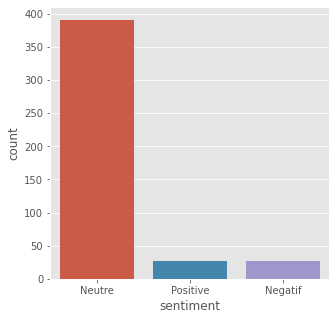

In [49]:
fig = plt.figure(figsize = (5,5))
sns.countplot(x = 'sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution des sentiments')

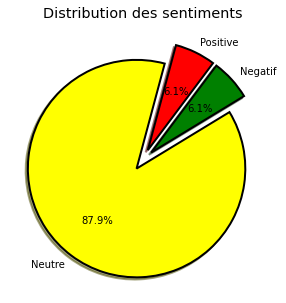

In [55]:
fig = plt.figure(figsize = (5,5))
colors = ("yellow","green", "red")
wp = {"linewidth":2, "edgecolor":"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow = True, colors = colors,
         startangle  = 75, wedgeprops= wp ,explode = explode, label = '' )
plt.title("Distribution des sentiments")

In [56]:
#WordCloud  tweet positifs

pos_tweets = text_df[text_df.sentiment == "Positive"]
pos_tweets=pos_tweets.sort_values(['polarite'], ascending =  False)
pos_tweets.head()

,contenu,polarite,sentiment
378,lmao gars clubhouse dit racisme musique france,0.6000,Positive
241,"great mouch ! peur pression , avoue coupe cour...",0.6000,Positive
77,"calais racisme primaire , nice racisme bien ai...",0.6000,Positive
220,effet apparemment condamn ! rends compte lanti...,0.5625,Positive
176,gentleman normalise tolre xnophobie sert . gen...,0.5000,Positive


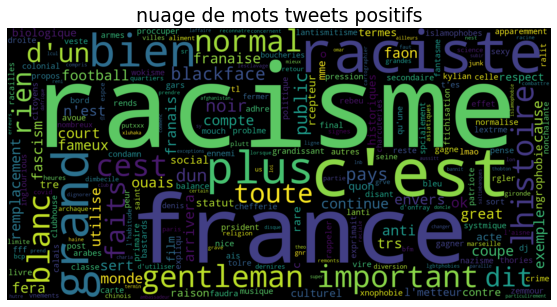

In [72]:
text = ' '.join([word for word in pos_tweets["contenu"]])
plt.figure(figsize = (10,5), facecolor= 'none')
wordcloud =  WordCloud(max_words =  250, width = 1600 , height = 800).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('nuage de mots tweets positifs', fontsize = 19)
plt.show()

In [68]:
#wordcloud tweets négatifs
neg_tweets = text_df[text_df.sentiment == "Negatif"]
neg_tweets=neg_tweets.sort_values(['polarite'], ascending =  False)
neg_tweets.head()

,contenu,polarite,sentiment
311,jai dcouvert racisme lislamophobie mme temps c...,-0.050000,Negatif
455,red flag= blagues racistes ( genre c'est mme p...,-0.100000,Negatif
119,"/ france , gaulois n'ont droit s'exprimer rass...",-0.162760,Negatif
120,maghrbins crient racisme france victimisent al...,-0.166667,Negatif
121,"crc lingalit raciale socits dmocratiques , deb...",-0.166667,Negatif


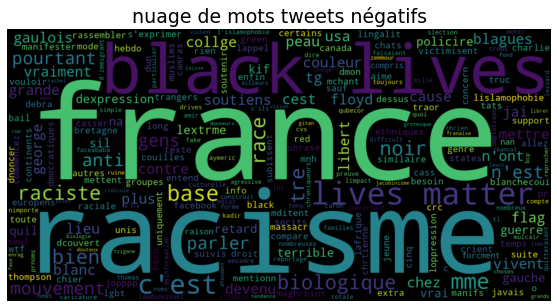

In [73]:
text = ' '.join([word for word in neg_tweets["contenu"]])
plt.figure(figsize = (10,5), facecolor= 'none')
wordcloud =  WordCloud(max_words =  250, width = 1600 , height = 800).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('nuage de mots tweets négatifs', fontsize = 19)
plt.show()

In [ ]:
#Tweet Neutre

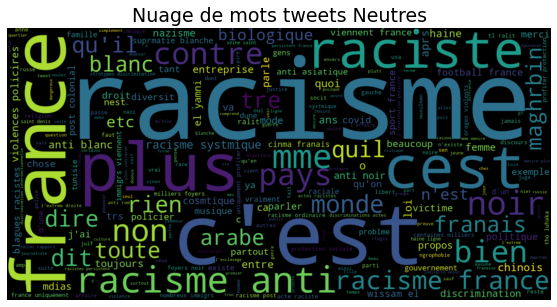

In [74]:
neut_tweets = text_df[text_df.sentiment == "Neutre"]
neut_tweets=neut_tweets.sort_values(['polarite'], ascending =  False)

text = ' '.join([word for word in neut_tweets["contenu"]])
plt.figure(figsize = (10,5), facecolor= 'none')
wordcloud =  WordCloud(max_words =  250, width = 1600 , height = 800).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Nuage de mots tweets Neutres', fontsize = 19)
plt.show()

In [75]:
vect = CountVectorizer (ngram_range = (1,2)).fit(text_df["contenu"])   

In [76]:
X = text_df["contenu"]
Y = text_df["sentiment"]
X = vect.transform(X)

In [78]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.3, random_state= 42)

In [79]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((311, 9829), (134, 9829), (311,), (134,))

### MACHINE LEARNING

In [151]:
LogReg = LogisticRegression()
LogReg.fit(x_train, y_train)
y_pred = LogReg.predict(x_test)

Logreg_acc = accuracy_score(y_pred, y_test)
Logreg_acc

0.9253731343283582

In [152]:
#Regression logistique 

LogReg = LogisticRegression()
LogReg.fit(x_train, y_train)
y_pred = LogReg.predict(x_test)


In [153]:
Logreg_acc = accuracy_score(y_pred, y_test)
Logreg_acc

0.9253731343283582

In [110]:
#ARBRE DE DECISION Optimisé

from sklearn import tree
model = tree.DecisionTreeClassifier()

In [112]:
param_dict = {
    "criterion" : ['gini', 'entropy'],
    "max_depth" : range(1, 10),
    "min_samples_split" : range(1,10),
    "min_samples_leaf" : range(1,5)
}

grid = GridSearchCV(model,
                   param_grid = param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=-10)

grid.fit(x_train, y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [115]:
y_pred_tree = grid.predict(x_test)
tree_acc = accuracy_score(y_pred_tree, y_test)
tree_acc

0.9402985074626866

In [113]:
#KNN optimisé
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 11), 'metric': ['euclidean', 'manhattan']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv = KFold(3, random_state = None))
grid_knn.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [116]:
model_GSCV = grid_knn.best_estimator_
pred_knn = model_GSCV.predict(x_test)
knn_acc = accuracy_score(pred_knn, y_test)
knn_acc

0.9104477611940298

In [131]:
knn_F1 = f1_score(y_test, pred_knn, average='weighted')
knn_F1


0.8677705223880597

### EVALUATION DES MODELES

In [156]:
#score regression logistique
reglog_acc = accuracy_score(y_test, y_pred)
reglog_F1 = f1_score(y_test, y_pred,average='weighted')
reglog_precison = precision_score(y_test, y_pred,average='weighted')
relog_recall= recall_score(y_test, y_pred,average='weighted')


#arbre de décision
tree_acc = accuracy_score(y_test, y_pred_tree)
tree_precision = precision_score(y_test, y_pred_tree,average='weighted')
tree_recall = recall_score(y_test, y_pred_tree,average='weighted')
tree_F1 = f1_score(y_test, y_pred_tree,average='weighted')

#KNN
knn_acc = accuracy_score(y_test, pred_knn)
knn_precision = precision_score(y_test, pred_knn,average='weighted')
knn_recall = recall_score(y_test, pred_knn,average='weighted')
knn_F1 = f1_score(y_test, pred_knn,average='weighted')



All_scoring_dict = {'Regression logistique':[reglog_acc,reglog_precison,relog_recall,reglog_F1]}
All_scoring_dict['Arbre de decision'] = [tree_acc,tree_precision,tree_recall,tree_F1]
All_scoring_dict['KNN'] = [knn_acc,knn_precision,knn_recall,knn_F1]


In [157]:
pd.DataFrame.from_dict(All_scoring_dict, orient = 'index', columns = ['Accuracy','Precision','Recall','F1 score'])

,Accuracy,Precision,Recall,F1 score
Regression logistique,0.925373,0.878788,0.925373,0.895925
Arbre de decision,0.940299,0.891734,0.940299,0.914712
KNN,0.910448,0.828915,0.910448,0.867771


In [158]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

     Negatif       1.00      0.80      0.89         5
      Neutre       0.94      1.00      0.97       122
    Positive       0.00      0.00      0.00         7

    accuracy                           0.94       134
   macro avg       0.65      0.60      0.62       134
weighted avg       0.89      0.94      0.91       134

